# All Spectrogram Code Setup

In [1]:
%matplotlib inline
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, stats
from sklearn.decomposition import NMF
import pandas as pd

def get_all_pat_chn_trials(base_data_dir, patient_num, session_idx, tot_num_channels, 
                           core_cat, trials_type, ord):
    # TODO: Fix the default norm value to be None, and allow other norms to flow through
    """Get all trials for each channel for a given category"""    
    
    patient_ref = f"P{patient_num:02}"
    #print("patient_ref", patient_ref, sep =": ")
    patient_data_dir = os.path.join(base_data_dir, f"{patient_ref}_specgram", 
                                    f"{trials_type}", 
                                    f"session_{session_idx:02}",
                                    f"{core_cat}")
    #print("patient_data_dir", patient_data_dir, sep =": ")
    patient_csv_refs = [os.path.join(patient_data_dir, f"{patient_ref}-ses-{session_idx:02}-chn-{channel_idx + 1:02}-{core_cat}.csv") 
                        for channel_idx in tot_num_channels]
    #print("patient_csv_refs", patient_csv_refs[0], sep =": ")
    all_patient_trials = [np.loadtxt(fname = patient_csv_ref, skiprows = 1, delimiter = ",") for 
                          patient_csv_ref in patient_csv_refs]
    
    # Normalize the trial based on the specified norm type
    if ord is not None:
        print(f"we are using the {ord}-norm to normalize trials")
        all_patient_trials = [trials / np.linalg.norm(trials, ord=ord, axis=1, keepdims=True) for trials in all_patient_trials]

    return all_patient_trials

def samp_idx_without_replace(np_arr, samp_prop, sample_rows):
    """Returns a list of unique row indices from the total number of trials"""
    if sample_rows:
        # sample the number of rows
        sample_type = 0
    else:
        # sample the number of columns
        sample_type = 1
    tot_num_idxs = np_arr.shape[sample_type]
    samp_num_rows = int(np.floor(tot_num_idxs * samp_prop))
    return sorted(random.sample(range(tot_num_idxs), samp_num_rows))

def erp_gen_spectrogram(x, fs, window, nperseg, noverlap, log_Sxx):
    """Generate the spectrogram and return the modulus (or log modulus)"""
    f, t, Sxx = signal.spectrogram(x = x, fs = fs, window = window, nperseg = nperseg, noverlap = noverlap)
    if log_Sxx:
        Sxx = np.log(Sxx)
    return f, t, Sxx

def erp_gen_welch(x, fs, window, nperseg, noverlap):
    """Estimate power spectral density using Welch’s method."""
    f, psd = signal.welch(x = x, fs = fs, window = window, nperseg = nperseg, noverlap = noverlap)
    return f, psd

def specgram_trials(arr_all_trials, fs, window, nperseg, 
                    trials_samp_idx, filter_row_idx, log_Sxx):
    """Produce a combined list of spectrograms concatenated by frequency (horizontally)"""
    if trials_samp_idx is None:
        # Produce spectrograms for all of the trials
        all_trial_idx = range(arr_all_trials.shape[0])
        trial_specgrams = [erp_gen_spectrogram(x=arr_all_trials[idx], fs=fs, window=window, nperseg=nperseg, 
                                               noverlap=noverlap, log_Sxx=log_Sxx)[2] for idx in all_trial_idx]
    else:
        # Produce spectrograms for only the specified trials (by trial indices)
        trial_specgrams = [erp_gen_spectrogram(x = arr_all_trials[idx], fs = fs, window = window, nperseg = nperseg, 
                                               noverlap=noverlap, log_Sxx=log_Sxx)[2] for idx in trials_samp_idx]
    
    # Concatenate the combined spectrograms across time i.e. horizontally
    comb_specgram = np.hstack(trial_specgrams)
    
    # Filter the rows of the combined spectrogram    
    if filter_row_idx is None:
        # Don't filter any rows in the combined spectrogram
        comb_specgram = comb_specgram
    else:
        comb_specgram = comb_specgram[filter_row_idx]
    return comb_specgram

def specgram_wrapper(arr_all_trials, tot_num_channels, fs, window, nperseg, 
                     trials_samp_idx, filter_row_idx, log_Sxx):
    """Wrapper to produce spectrograms across all trials (or samples thereof) and the specified
       channels for the particular patient"""
    all_channels_specgrams = [specgram_trials(arr_all_trials=arr_all_trials[channel_idx],
                                              fs = fs, window = window, nperseg = nperseg,
                                              trials_samp_idx=trials_samp_idx, filter_row_idx=filter_row_idx,
                                              log_Sxx=log_Sxx) 
                              for channel_idx in range(len(tot_num_channels))]
    comb_all_channels_specgrams = np.hstack(all_channels_specgrams)
    return comb_all_channels_specgrams

def time_sample_specgram(comb_specgram, time_samp_idx):
    """samples a combined spectrogram of signals (horizontally stacked) and samples by time i.e. shortens by column"""
    return comb_specgram[:, time_samp_idx]    

def nmf_specgrams(comb_specgram, n_components=5, init='random', random_state=0, beta_loss='itakura-saito', solver = 'mu', max_iter=200):
    model = NMF(n_components=n_components, init=init, random_state=random_state, beta_loss=beta_loss, solver=solver, max_iter=max_iter)
    W = model.fit_transform(X=comb_specgram)
    H = model.components_
    return W, H

def nmf_wrapper(comb_all_channels_specgrams, n_components=5, init='random', random_state=0, 
                beta_loss='itakura-saito', solver = 'mu', max_iter=200):
    W, H = nmf_specgrams(comb_all_channels_specgrams, n_components=n_components, init=init, random_state=random_state, 
                         beta_loss=beta_loss, solver=solver, max_iter=max_iter)
    print("V", comb_all_channels_specgrams.shape, sep = ": ")
    print("W", W.shape, sep = ": ")
    print("H", H.shape, sep = ": ")
    return comb_all_channels_specgrams, W, H

### Plot the "basis" vectors i.e. columns of W

def plotW(W, log=True, x_ticks_l=None):
    if log:
        W_plt = np.log(W)
    else:
        W_plt = W
    n_components = W.shape[1]    
    for n in range(W.shape[1]):
        plt.style.use('seaborn')
        plt.figure(figsize=(20, 16), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(np.ceil(n_components/2.0), 2, n+1)
        plt.plot(W_plt[:,n])
        plt.title(f'Plot of W Component {n + 1}', fontsize=16)
        #plt.ylim(-2, W_plt.max())
        if x_ticks_l is None:
            plt.xlim(0, W_plt.shape[0])
        else:
            plt.xticks(range(0, W_plt.shape[0]), np.around(x_ticks_l), rotation='vertical')
        plt.ylabel(f'Component {n + 1}')

### Plot the rows of H i.e. the temporal activations

def plotH(H, log=False, y_ticks_l=None):
    print(H.shape[1])
    if log:
        H_plt = np.log(H)
    else:
        H_plt = H
    n_components = H.shape[0]    
    for n in range(H_plt.shape[0]):
        plt.style.use('seaborn')
        plt.figure(figsize=(16, 14), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(np.ceil(n_components/2.0), 2, n+1)
        plt.title(f'Plot of H Component {n + 1}', fontsize=16)
        plt.plot(H_plt[n])
        #if y_ticks_l is None:
        #    plt.ylim(0, H_plt.shape[1])
        #else:
        #    plt.yticks(range(0, H_plt.shape[1]), np.around(y_ticks_l, decimals=-1), rotation='vertical')
        #plt.ylim(0, H.max())
        plt.xlim(0, H_plt.shape[1])
        plt.ylabel(f'Component {n + 1}')
        
def entire_specgram_nmf_wrapper(base_data_dir, core_cat, trials_type,
                                patient_num, session_idx, tot_num_channels, samp_trial_pop, 
                                noverlap,
                                ord=None,
                                time_samp_prop=0.2,
                                filter_row_idx=None,                                
                                log_Sxx=False,
                                fs=1e3, window='hann', nperseg=128,
                                n_components=8, 
                                init='random', 
                                random_state=0, 
                                beta_loss='itakura-saito', 
                                solver = 'mu',
                                max_iter=400):
    
    # Get all the channels and trials (DONE)
    all_patient_trials = get_all_pat_chn_trials(base_data_dir=base_data_dir, patient_num=patient_num, 
                                                session_idx=session_idx, tot_num_channels=tot_num_channels, 
                                                core_cat=core_cat, trials_type=trials_type, ord=ord)

    trials_samp_idx = samp_idx_without_replace(np_arr=all_patient_trials[0], samp_prop=samp_trial_pop, 
                                               sample_rows=True)
    print(len(trials_samp_idx))

    # Fit the spectrograms and hstack the spectrograms
    comb_all_channels_specgrams = specgram_wrapper(arr_all_trials=all_patient_trials, 
                                                   trials_samp_idx=trials_samp_idx, 
                                                   tot_num_channels=tot_num_channels,
                                                   fs=fs, window=window, nperseg=nperseg,
                                                   filter_row_idx=filter_row_idx, 
                                                   log_Sxx=log_Sxx)

    # randomly sample across time
    time_samp_idx = samp_idx_without_replace(np_arr=comb_all_channels_specgrams, 
                                             samp_prop=time_samp_prop, 
                                             sample_rows=False)
    
    print("comb_all_channels_specgrams:", comb_all_channels_specgrams.shape, sep = " ")
    print("time_samp_idx length:", len(time_samp_idx), sep = " ")

    comb_specgram_time_sample = time_sample_specgram(comb_specgram=comb_all_channels_specgrams, 
                                                     time_samp_idx=time_samp_idx)
    
    print("comb_specgram_time_sample:", comb_specgram_time_sample.shape, sep=" ")
    
    print("STARTING NMF...")
    
    # perform NMF
    V, W, H = nmf_wrapper(comb_all_channels_specgrams=comb_specgram_time_sample, 
                          n_components=n_components,
                          init=init, 
                          random_state=random_state, 
                          beta_loss=beta_loss, 
                          solver=solver,
                          max_iter=max_iter)
    
    print("NMF COMPLETE!")
    
    return V, W, H        

# 85 Channels - P41, Faces, Session 1

### Perform NMF for P41 - 85 Channels, Faces, Session 1 - DENORMALIZED TRIALS, IS DIVERGENCE NMF
#### (100% sampling of trials, 100% sampling of time)

In [2]:
np.random.seed(seed=103224)

In [120]:
base_data_dir = "/Users/shamindras/PERSONAL/LEARNING/REPOS/neuroada_analysis/data/localizer_erp"
patient_num = 41
tot_num_channels = range(85)
trials_type = "category"
session_idx = 1
core_cat = "Faces"

# Spectrogram parameters
fs = 1e3
window = 'hann'
nperseg = 192
noverlap = 96
log_Sxx=False
spec_trial_num = 10 # Specific Trial Index that we are going to test
spec_trial_idx = spec_trial_num - 1

channel_num = 10
channel_idx = channel_num - 1

base_data_dir = "/Users/shamindras/PERSONAL/LEARNING/REPOS/neuroada_analysis/data/localizer_erp"
ord = None # No normalization trials
samp_trial_pop = 1.0 # 100% sampling of trials
time_samp_prop = 1.0 # 100% sampling of time
filter_row_idx=range(21)
n_components = 8 
init = 'random' 
random_state = 0
beta_loss = 'itakura-saito' # IS Divergence
solver = 'mu'
max_iter = 400

# Get all trials for by channel

In [4]:
all_pat_chn_trials = get_all_pat_chn_trials(base_data_dir=base_data_dir, patient_num=patient_num, 
                                   session_idx=session_idx, tot_num_channels=tot_num_channels, 
                                   core_cat=core_cat, trials_type=trials_type, ord=ord)

## Run Spectrogram for a single trial

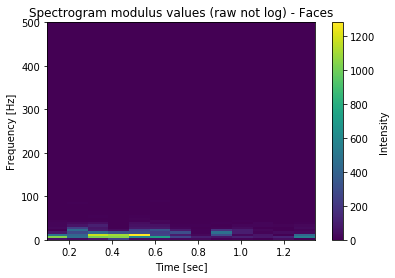

In [5]:
# Fit the spectrogram - no log
f, t, Sxx = erp_gen_spectrogram(x = all_pat_chn_trials[0][0], fs = fs, window = window, nperseg = nperseg, noverlap = noverlap, log_Sxx=log_Sxx)

# Plot the spectrogram
plt.pcolormesh(t, f, Sxx)
plt.title(f"Spectrogram modulus values (raw not log) - {core_cat}")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar().set_label('Intensity')
plt.show()

In [6]:
V, W, H = entire_specgram_nmf_wrapper(base_data_dir=base_data_dir, core_cat=core_cat, trials_type=trials_type, ord=ord,
                                      patient_num=patient_num, session_idx=session_idx, 
                                      tot_num_channels=tot_num_channels, 
                                      samp_trial_pop=samp_trial_pop,
                                      time_samp_prop=time_samp_prop,
                                      filter_row_idx=filter_row_idx,
                                      fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
                                      log_Sxx=log_Sxx,
                                      n_components=n_components, 
                                      init=init, 
                                      random_state=random_state, 
                                      beta_loss=beta_loss, 
                                      solver=solver,
                                      max_iter=max_iter)

84
comb_all_channels_specgrams: (21, 99960)
time_samp_idx length: 99960
comb_specgram_time_sample: (21, 99960)
STARTING NMF...
V: (21, 99960)
W: (21, 8)
H: (8, 99960)
NMF COMPLETE!


99960


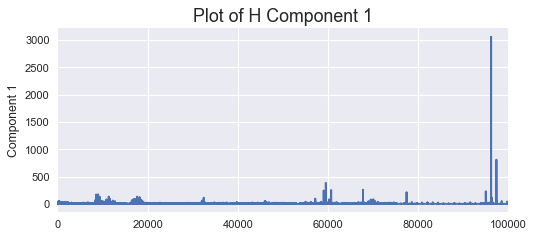

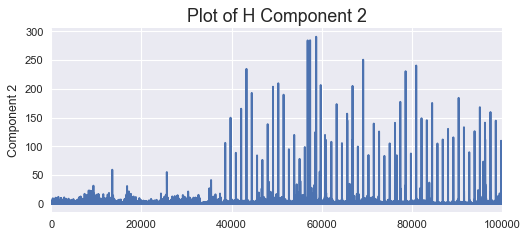

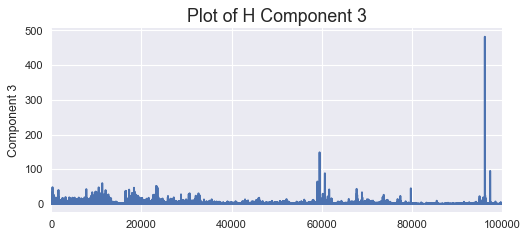

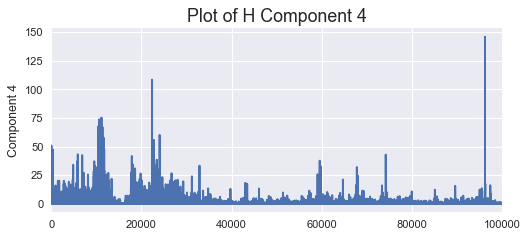

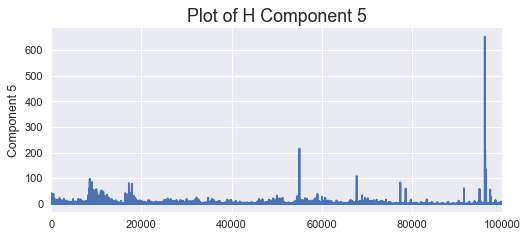

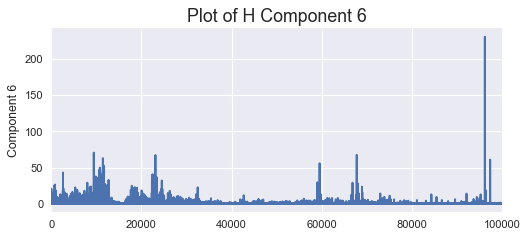

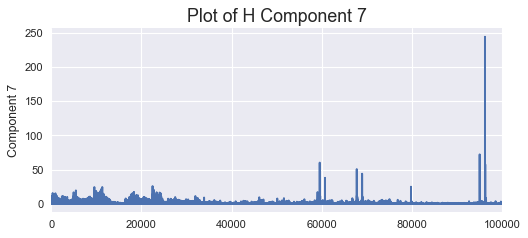

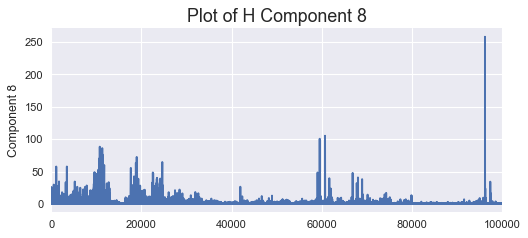

In [7]:
#freq_ticks = np.around(np.linspace(0, 100, num=len(filter_row_idx)), decimals=0)
freq_ticks = f[filter_row_idx]
#freq_ticks

# W-components
#plotW(W = W, log=False, x_ticks_l=freq_ticks)

# H-components
plotH(H = H, log=False, y_ticks_l=None)

## Get the max - k values from array

In [8]:
def get_topk_vals_and_idx_byrow(a, k):
    
    # Find sorted indices for each row
    sorted_row_idx = np.argsort(a, axis=1)[:,a.shape[1]-k::]

    # Setup column indexing array
    col_idx = np.arange(a.shape[0])[:, None]

    # Use the column-row indices to get specific elements from input array. 
    # Please note that since the column indexing array isn't of the same shape 
    # as the sorted row indices, it will be broadcasted
    top_vals = a[col_idx, sorted_row_idx]
    
    return sorted_row_idx, top_vals

## Get the indices corresponding to max $H$ components - 1 row per component

In [9]:
sorted_row_idx, top_vals = get_topk_vals_and_idx_byrow(a=H, k=3)
sorted_row_idx

array([[59517, 97328, 96152],
       [56843, 57389, 58733],
       [97328, 59517, 96152],
       [11137, 22351, 96152],
       [96216, 55037, 96152],
       [67751,  9459, 96152],
       [59517, 94976, 96152],
       [60694, 96153, 96152]])

In [10]:
def get_outlier_indices(outlier_idx, specgram_width, num_trials, num_channels, ret_type):
    outlier_loc = outlier_idx + 1
    channel_num = np.ceil(outlier_loc/(specgram_width * num_trials))
    channel_idx = channel_num - 1
    trial_num = np.ceil((outlier_loc % (channel_idx * num_trials))/specgram_width)
    trial_idx = trial_num - 1
    
    if ret_type == "channel_num":
        out = [int(chn) for chn in channel_num]
    elif ret_type == "channel_idx":
        out = [int(chn_idx) for chn_idx in channel_idx]
    elif ret_type == "trial_num":
        out = [int(trl) for trl in trial_num]
    elif ret_type == "trial_idx":
        out = [int(trl_idx) for trl_idx in trial_idx]
    else:
        pass
    
    return out

## Get the unique indices across all $H$ components

In [11]:
all_outlier_idx = sorted_row_idx.flatten(order='C')
all_outlier_idx_unq = np.unique(all_outlier_idx)
all_outlier_idx_unq

array([ 9459, 11137, 22351, 55037, 56843, 57389, 58733, 59517, 60694,
       67751, 94976, 96152, 96153, 96216, 97328])

In [12]:
channel_idx = get_outlier_indices(outlier_idx=all_outlier_idx_unq, 
                                  specgram_width=len(t), 
                                  num_trials=all_pat_chn_trials[0].shape[0], 
                                  num_channels=len(all_pat_chn_trials),
                                  ret_type = "channel_idx")
trial_idx = get_outlier_indices(outlier_idx=all_outlier_idx_unq, 
                                  specgram_width=len(t), 
                                  num_trials=all_pat_chn_trials[0].shape[0], 
                                  num_channels=len(all_pat_chn_trials),
                                  ret_type = "trial_idx")

print("channel_idx:\n", channel_idx) 
print("trial_idx:\n", trial_idx)

channel_idx:
 [8, 9, 19, 46, 48, 48, 49, 50, 51, 57, 80, 81, 81, 81, 82]
trial_idx:
 [3, 39, 0, 67, 28, 67, 79, 51, 51, 51, 64, 64, 64, 68, 64]


In [13]:
out_chn_trl = list(zip(channel_idx, trial_idx))
out_chn_trl

[(8, 3),
 (9, 39),
 (19, 0),
 (46, 67),
 (48, 28),
 (48, 67),
 (49, 79),
 (50, 51),
 (51, 51),
 (57, 51),
 (80, 64),
 (81, 64),
 (81, 64),
 (81, 68),
 (82, 64)]

In [14]:
out_trials = [all_pat_chn_trials[x[0]][x[1]] for x in out_chn_trl]
out_trials_v = np.vstack(out_trials)
out_trials_v.shape

(15, 1500)

In [29]:
specgrams = [erp_gen_spectrogram(x = trials, fs = fs, window = window, nperseg = nperseg, noverlap = noverlap, log_Sxx=True)[2] 
             for trials in out_trials_v]
specgrams[0].shape

(97, 14)

Useful color [reference](https://matplotlib.org/examples/color/colormaps_reference.html) for matplotlib

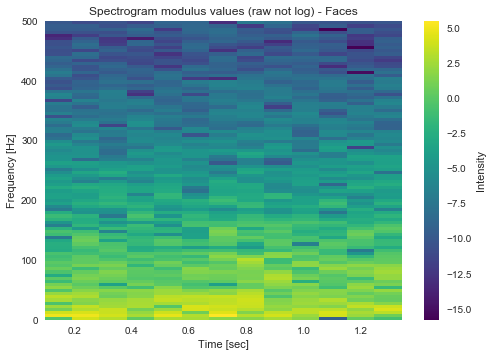

In [30]:
plt.pcolormesh(t, f, specgrams[2], cmap='viridis')
plt.title(f"Spectrogram modulus values (raw not log) - {core_cat}")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar().set_label('Intensity')
plt.show()

In [151]:
def plot_specgrams(specgrams, f, t):
    for idx, sgram in enumerate(specgrams):
        plt.figure(figsize=(22, 36), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(np.ceil(len(specgrams)/2.0), 2, idx + 1)
        plt.pcolormesh(t, f, sgram, cmap='viridis')
        plt.title(f"Spectrogram modulus values (raw not log) - {core_cat}")
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.colorbar().set_label('Intensity')
        plt.show()

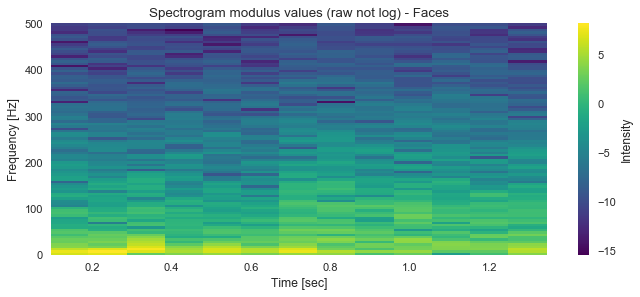

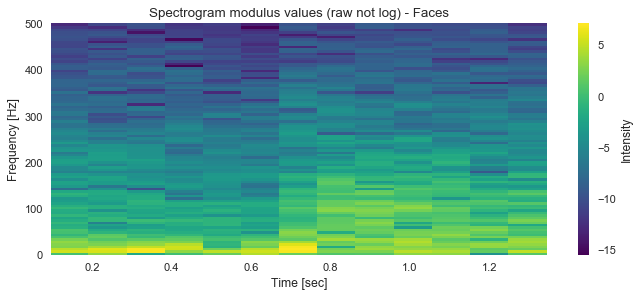

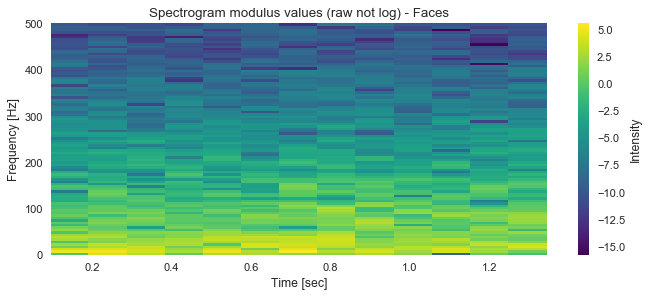

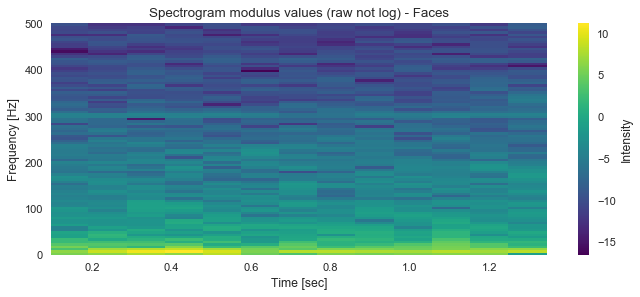

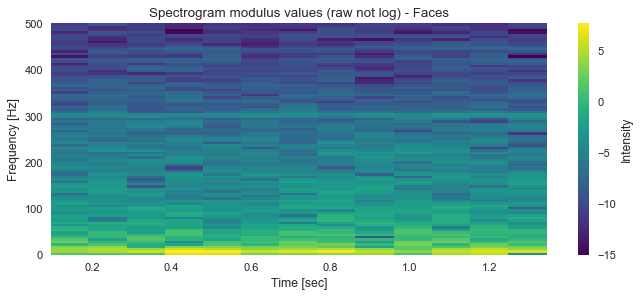

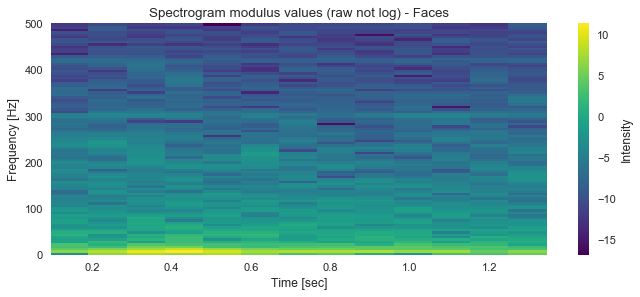

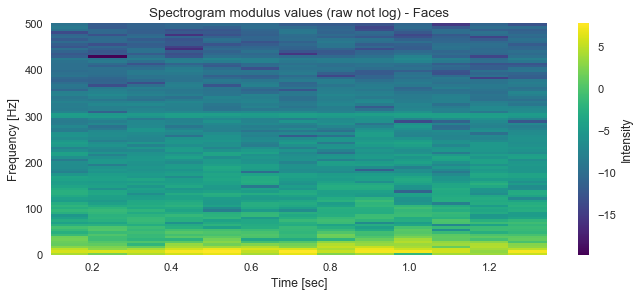

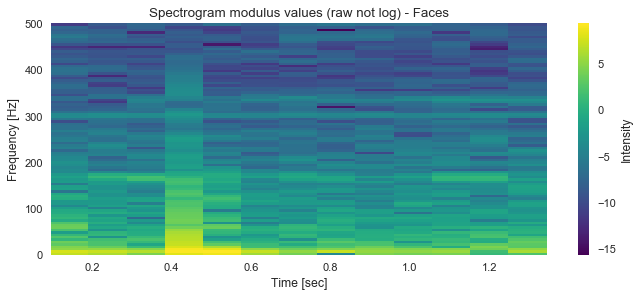

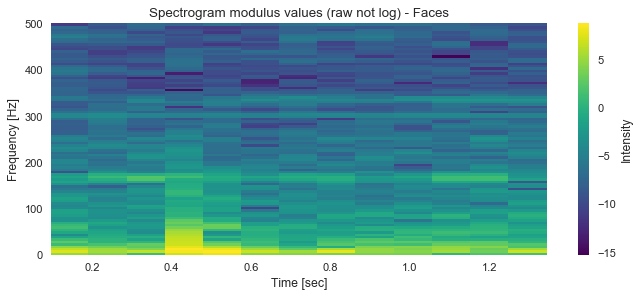

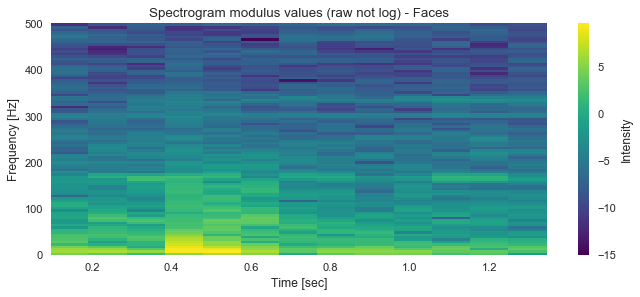

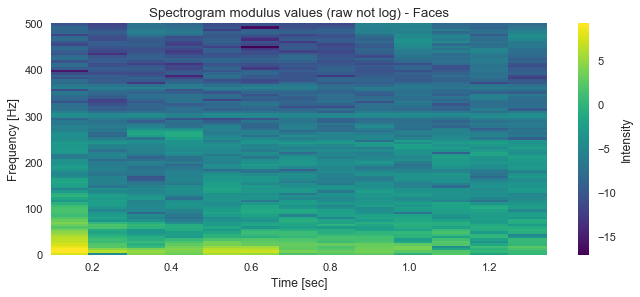

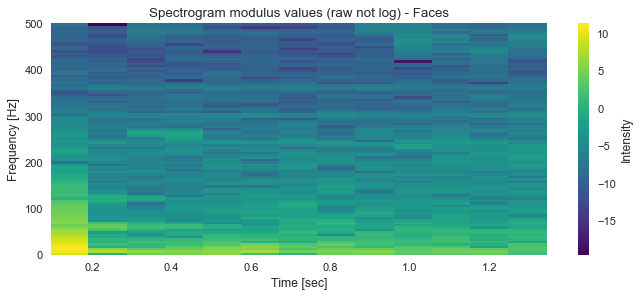

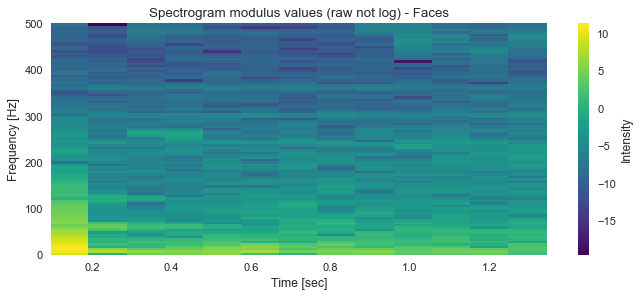

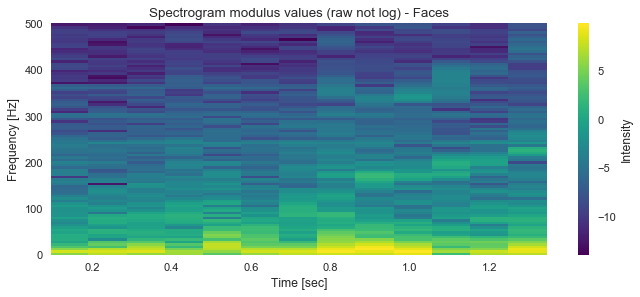

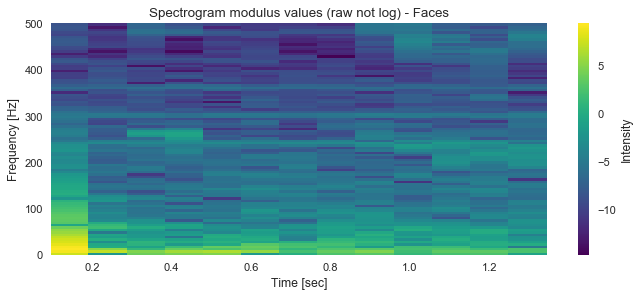

In [152]:
plot_specgrams(specgrams=specgrams, f=f, t=t)

## Get the properly scaled specgtrogram

In [35]:
t

array([0.096, 0.192, 0.288, 0.384, 0.48 , 0.576, 0.672, 0.768, 0.864,
       0.96 , 1.056, 1.152, 1.248, 1.344])

In [37]:
t[2:5]

array([0.288, 0.384, 0.48 ])

In [44]:
trunc_mat = Sxx[:, 2:5]
mu = np.mean(a=trunc_mat, axis=1)
sd = np.std(a=trunc_mat, axis=1)

In [50]:
zscore_trunc = stats.zscore(a=trunc_mat, axis=1)
zscore_trunc_manual = np.apply_along_axis(func1d=zscore_manl(val, mu=mu, sd=sd), axis=1, arr=trunc_mat)

NameError: name 'val' is not defined

In [64]:
arr = Sxx[1, :]
trunc_arr = arr[2:5]
mu = np.mean(trunc_arr)
sd = np.std(trunc_arr)
arr_zscore = (arr - mu)/sd
zscore_trunc = stats.zscore(a=trunc_mat, axis=1)
arr_zscore_trunc = arr_zscore[2:5]

In [66]:
# Check
print(zscore_trunc[1, :] - arr_zscore_trunc)

[0. 0. 0.]


In [136]:
def zscore_manl(arr, col_min_rng, col_max_rng):
    trunc_arr = arr[col_min_rng:col_max_rng]
    mu = np.mean(trunc_arr)
    sd = np.std(trunc_arr, ddof=1)
    return (arr - mu)/sd

In [137]:
zscore_manl(arr=Sxx[0, :], col_min_rng=2, col_max_rng=5)

array([-0.458059  , -0.70858896, -0.42203232,  1.14183115, -0.71979883,
       -0.54023523, -0.75099286, -0.72998168, -0.95645592, -0.90472334,
       -0.98006409, -0.65331883, -1.02571702, -0.97393759])

In [138]:
out = [zscore_manl(arr=Sxx[row_idx, :], col_min_rng=2, col_max_rng=5) for row_idx in range(Sxx.shape[0])]

In [139]:
out_v = np.vstack(out)
out_v.shape

(97, 14)

In [140]:
def only_specgram_trials(arr_all_trials, fs, window, nperseg, noverlap,
                    trials_samp_idx=None, filter_row_idx=None, log_Sxx=False):
    """Produce a combined list of spectrograms concatenated by frequency (horizontally)"""
    if trials_samp_idx is None:
        # Produce spectrograms for all of the trials
        all_trial_idx = range(arr_all_trials.shape[0])
        trial_specgrams = [erp_gen_spectrogram(x = arr_all_trials[idx], fs = fs, window = window, nperseg = nperseg,
                                               noverlap=noverlap, log_Sxx=log_Sxx)[2] for idx in all_trial_idx]
    else:
        # Produce spectrograms for only the specified trials (by trial indices)
        trial_specgrams = [erp_gen_spectrogram(x = arr_all_trials[idx], fs = fs, window = window, nperseg = nperseg, 
                                               noverlap=noverlap, log_Sxx=log_Sxx)[2] for idx in trials_samp_idx]
    
    # Filter the rows of the combined spectrogram    
    if filter_row_idx is None:
        # Don't filter any rows in the combined spectrogram
        trial_specgrams = trial_specgrams
    else:
        trial_specgrams = [specgram[filter_row_idx] for specgram in trial_specgrams]
    return trial_specgrams

In [141]:
def zscore_specgram(Sxx, col_min_rng, col_max_rng):
    out = [zscore_manl(arr=Sxx[row_idx, :], col_min_rng=col_min_rng, col_max_rng=col_max_rng) 
           for row_idx in range(Sxx.shape[0])]
    return np.vstack(out)

In [142]:
def zscore_specgram_wrapper(arr_all_trials, col_min_rng, col_max_rng, 
                            fs, window, nperseg, noverlap,
                            trials_samp_idx, filter_row_idx, log_Sxx):
    """"""
    # Get spectrograms for all of the trials
    specgram_trials = only_specgram_trials(arr_all_trials=arr_all_trials, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
                                           trials_samp_idx=trials_samp_idx, filter_row_idx=filter_row_idx, log_Sxx=log_Sxx)

    # Z-score sprectrograms
    z_specgrams = [zscore_specgram(Sxx, col_min_rng=col_min_rng, col_max_rng=col_max_rng)
                   for Sxx in specgram_trials]
    #print(f"the dimension of z_specgrams[0] is {z_specgrams[0].shape}")
    
    comb_z_specgrams = np.dstack(z_specgrams)
    #print(f"the dimension of comb_z_specgrams is {comb_z_specgrams.shape}")
    
    # Get mean across corresponding elements of the spectrograms
    mean_z_specgrams = np.mean(z_specgrams, axis=0)
    #print(f"the dimension of mean_z_specgrams is {mean_z_specgrams.shape}")
    
    return mean_z_specgrams

## Run it!

In [143]:
base_data_dir = "/Users/shamindras/PERSONAL/LEARNING/REPOS/neuroada_analysis/data/localizer_erp"
patient_num = 41
tot_num_channels = range(85)
trials_type = "category"
session_idx = 1
core_cat = "Faces"
ord = None # L2 norm

# Spectrogram parameters
fs = 1e3
window = 'hann'
nperseg = 192
noverlap = 96
log_Sxx=False
spec_trial_num = 10 # Specific Trial Index that we are going to test
spec_trial_idx = spec_trial_num - 1

channel_num = 10
channel_idx = channel_num - 1

In [144]:
zs = zscore_specgram_wrapper(arr_all_trials=all_pat_chn_trials[9], col_min_rng=1, col_max_rng=5, 
                            fs=fs, window=window, nperseg=nperseg, noverlap=noverlap,
                            trials_samp_idx=None, filter_row_idx=None, log_Sxx=False)

In [145]:
zs.shape

(97, 14)

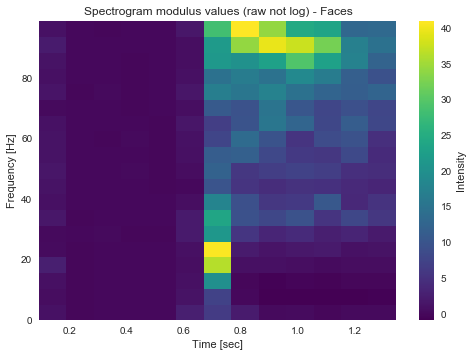

In [146]:
plt.pcolormesh(t, f[range(20)], zs[range(20), :], cmap='viridis')
plt.title(f"Spectrogram modulus values (raw not log) - {core_cat}")
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar().set_label('Intensity')
plt.show()